<a href="https://colab.research.google.com/github/RifatMuhtasim/NLP_Natural_Language_Processing/blob/main/Learn/17.Bag_of_n_Grams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News Category Classification Problem

In [1]:
import pandas as pd
import numpy as np
import spacy

## Data Acquisation

In [2]:
df = pd.read_json("https://raw.githubusercontent.com/codebasics/nlp-tutorials/main/11_bag_of_n_grams/news_dataset.json")
df.head()

,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [3]:
#display each category with their value counts
df['category'].value_counts()

category
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: count, dtype: int64

Here we see that this dataset is an imbalanced dataset. To make balanced dataset we use undersampling technique.

## Text Extraction & Cleanup

In [4]:
#Undersampling Technique to make dataset balanced
min_sample = 1381
business_df = df[df['category'] == "BUSINESS"].sample(min_sample)
sports_df = df[df['category'] == "SPORTS"].sample(min_sample)
crime_df = df[df['category'] == "CRIME"].sample(min_sample)
science_df = df[df['category'] == "SCIENCE"].sample(min_sample)

#Create a new dataset using undersampling
df_balanced = pd.concat([business_df, sports_df, crime_df, science_df], axis="rows")
df_balanced['category'].value_counts()

category
BUSINESS    1381
SPORTS      1381
CRIME       1381
SCIENCE     1381
Name: count, dtype: int64

In [5]:
#Convert category column to numeric
category_label = {"BUSINESS": 0, "SPORTS": 1, "CRIME": 2, "SCIENCE": 3}

df_balanced['category'] = df_balanced['category'].map(category_label)
df_balanced.sample(5)

,text,category
2404,From Gates To Zuckerberg To... Kalanick? What ...,0
9878,ESPN Host Says What You've Been Thinking About...,1
8616,10 Father's Day Gifts for the Business Owner L...,0
6951,Plane Hit Bald Eagle Before Crashing In Alaska...,2
7191,John Calipari Hopes To Keep Improving As Kentu...,1


## Pre-processing

In [6]:
#load pretrained model
nlp = spacy.load("en_core_web_sm")

#Pre-processing text to remove stop words and find the base word
def Preprocess(text):
    doc = nlp(text)

    filtered_text = []
    for token in doc:
        if not token.is_stop and not token.is_punct:  #Remove Stop words and Punctuations
            filtered_text.append(token.lemma_)   #Return Base Word
    return " ".join(filtered_text)

In [7]:
#Tokenization and Lemmatization for text words
df_balanced['new_text'] = df_balanced['text'].apply(Preprocess)
df_balanced.head()

,text,category,new_text
4687,It's 2015. How Are We Still Having These Conve...,0,2015 have conversation person kick ass negotia...
2743,The Financial Crisis Film 'Boom Bust Boom' Fal...,0,Financial Crisis Film Boom Bust Boom fall Prey...
2683,Follow Panama: Dollarize Most central banks do...,0,follow Panama dollarize central bank thing pro...
11105,45 U.S. Trade Groups Beg Trump: Don't Impose T...,0,45 U.S. Trade Groups Beg Trump impose tariff C...
9210,"Who is an Employee, Joint Employee, or Indepen...",0,Employee Joint Employee Independent Contractor...


## Feature Engineering

In [8]:
#Train text split
from sklearn.model_selection import train_test_split

X = df_balanced['new_text']
y = df_balanced['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train[:5]

8610     dangerous Cities America 400 violent crime 100...
1853                    watch strange way Jumbo Squid talk
12563    Billionaire Credibility Debunk Trump Warren Bu...
12685    nearly third marketer give consumer want simpl...
8680     break rule feel good intriguingly people lie c...
Name: new_text, dtype: object

In [9]:
#Convert word to number using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer(ngram_range=(1, 2))  #Bag of 2-Grams
v.fit(X_train.values)
X_train_counts = v.transform(X_train.values)

#display first 5 text on counts format
X_train_counts.toarray()[:5]

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Model Building

In [10]:
#Use Multinomial Naive Bayes algorithm
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_counts, y_train)

MultinomialNB()

In [11]:
#X_test Prediction and check accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#convert X_test to number
X_test_counts = v.transform(X_test)

y_pred = model.predict(X_test_counts)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.8760180995475113


## Evaluation

In [12]:
#show the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.85       276
           1       0.93      0.87      0.90       276
           2       0.86      0.92      0.89       277
           3       0.92      0.81      0.86       276

    accuracy                           0.88      1105
   macro avg       0.88      0.88      0.88      1105
weighted avg       0.88      0.88      0.88      1105



Text(50.722222222222214, 0.5, 'Truth')

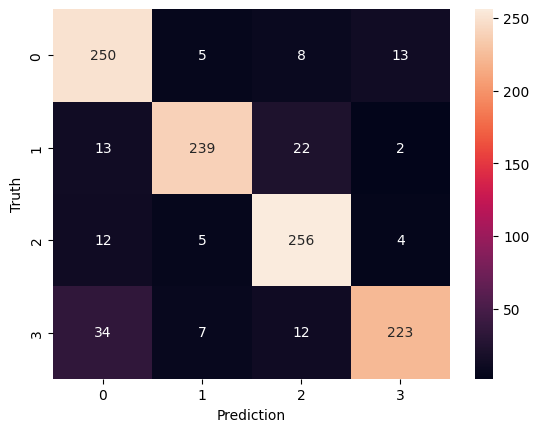

In [13]:
#plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

#confution matrix
cm = confusion_matrix(y_test, y_pred)

#plot
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Prediction")
plt.ylabel("Truth")

# Use Pipeline to reduce code

In [14]:
from sklearn.pipeline import Pipeline

#create pipeline
clf = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 5))),
    ('MulitinomialNB', MultinomialNB())
])

#model fitting
clf.fit(X_train, y_train)

#prediction
y_pred = clf.predict(X_test)

#classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       276
           1       0.94      0.86      0.90       276
           2       0.85      0.92      0.89       277
           3       0.92      0.81      0.86       276

    accuracy                           0.88      1105
   macro avg       0.88      0.88      0.88      1105
weighted avg       0.88      0.88      0.88      1105

